# Noiseless_integrable_Traceout

In [3]:
import sys
sys.path.insert(0, '../../../../src_tf/')

import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
import multiprocessing as mp
import tensorflow as tf
import random
import pickle as pkl

from qiskit.quantum_info import Operator, Statevector
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm
from math import ceil

from quantum_circuits import integrable_circuit, nonintegrable_circuit_star, integrable_circuit_star
from quantum_tools import circuit_to_matrix
from kraus_channels import isomery_to_kraus, KrausMap
from quantum_channel import ConcatChannel, DilutedChannel, IdentityChannel
from utils import numberToBase
from spectrum import complex_spacing_ratio, channel_spectrum, Spectrum, mean_spacing, coat_spectrum
from analysis import spectrum_to_angular, spectrum_to_radial, hist_ensamble
from qiskit.circuit.library import iSwapGate, XGate, YGate, HGate, CXGate, RGate, RZGate

#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=1)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


## Circuits

In [4]:
def integrable_circuit(n, L):
    theta_list = [np.random.uniform(-np.pi, np.pi, n) for i in range(L)]
    sqrt_iSWAP = iSwapGate().power(1 / 2)

    circuit = qk.QuantumCircuit(n)
    for i, theta in enumerate(theta_list):

        offset = i%2
        for j in range(n):
            circuit.rz(theta[j], j)

        for j in range((n - offset) // 2):
            circuit.append(sqrt_iSWAP, [2 * j + offset, 2 * j + 1 + offset])


    return circuit


def nonintegrable_circuit(n, L):
    theta_list = [np.random.uniform(-np.pi, np.pi, 2*n) for i in range(L)]
    sqrt_iSWAP = iSwapGate().power(1 / 2)

    circuit = qk.QuantumCircuit(n)
    for i, theta in enumerate(theta_list):

        offset = i%2
        for j in range(n):
            circuit.ry(theta[j], j)
            circuit.rz(theta[j+n], j)

        for j in range((n - offset) // 2):
            circuit.append(sqrt_iSWAP, [2 * j + offset, 2 * j + 1 + offset])


    return circuit


def haar_random(n, L):
    U = qk.quantum_info.random_unitary(2**n).data
    return U

def sample_csr(n, n_anc, reps, circuit_type, L):
    map_list = []
    spectra_list = []
    csr_list = []
    for _ in tqdm(range(reps)):
        circuit = circuit_type(n+n_anc, L)
        U = Operator(circuit).data
        kraus_map = isomery_to_kraus(U, rank = 2**n_anc)

        map_list.append(kraus_map)
        
        spectrum = channel_spectrum(kraus_map)
        spectra_list.append(spectrum)
        csr = complex_spacing_ratio(spectrum, log=False)
        csr_list.append(csr)

    return  map_list, spectra_list, csr_list

def save_spectrum(spectrum, filename):
    csr_array = np.real(spectrum.get_spectrum(is_complex=False))
    np.savetxt(filename, csr_array)

def save_heatmap(heatmap, filename):
    n = heatmap.shape[0]
    grid = np.arange(n)
    x, y = np.meshgrid(grid, grid)

    heatmap = heatmap.flatten()
    x = x.flatten()
    y = y.flatten()

    data = np.array([x, y, heatmap]).T
    np.savetxt(filename, data)


## Integrable

  0%|          | 0/1000 [00:00<?, ?it/s]

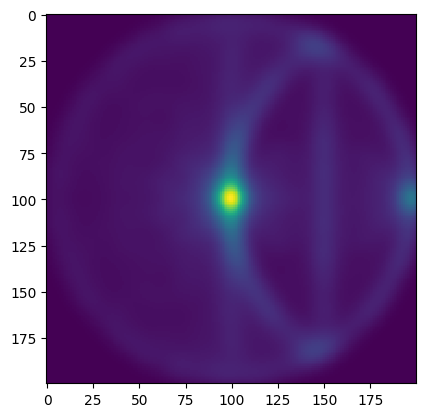

In [36]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

n = 4
n_anc = 1
d = 2**n
reps = 1000
L = 5

maps_integrable_list, spectra_integrable_list, csr_integrable_list = sample_csr(n, n_anc, reps, integrable_circuit, L)

csr_integrable = Spectrum(csr_integrable_list)

csr_integrable_coat = coat_spectrum(csr_integrable, sigma = 0.05, grid_size=200)

plt.imshow(csr_integrable_coat, interpolation='nearest')
plt.show()
    

In [39]:
save_spectrum(csr_integrable, 'book_keeping/integrable_crs_eigenvalues_L=5_numerical.txt')
save_heatmap(csr_integrable_coat, 'book_keeping/integrable_crs_density_L=5_numerical.txt')

  0%|          | 0/1000 [00:00<?, ?it/s]

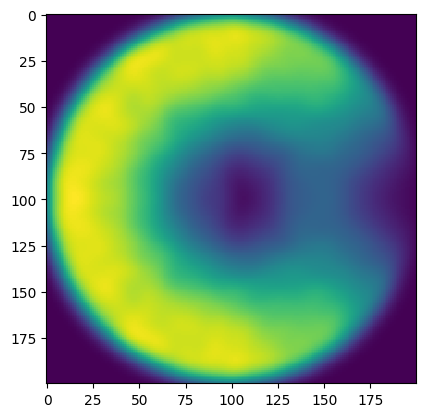

In [34]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

n = 4
n_anc = 1
d = 2**n
reps = 1000
L = 10

maps_nonintegrable_list, spectra_nonintegrable_list, csr_nonintegrable_list = sample_csr(n, n_anc, reps, haar_random, L)

csr_nonintegrable = Spectrum(csr_nonintegrable_list)
csr_nonintegrable_coat = coat_spectrum(csr_nonintegrable, sigma = 0.05, grid_size=200)

plt.imshow(csr_nonintegrable_coat, interpolation='nearest')
plt.show()
    

In [35]:
save_spectrum(csr_nonintegrable, 'book_keeping/nonintegrable_crs_eigenvalues_Haar_numerical.txt')
save_heatmap(csr_nonintegrable_coat, 'book_keeping/nonintegrable_crs_density_Haar_numerical.txt')

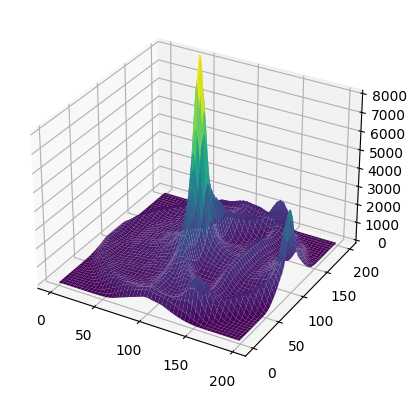

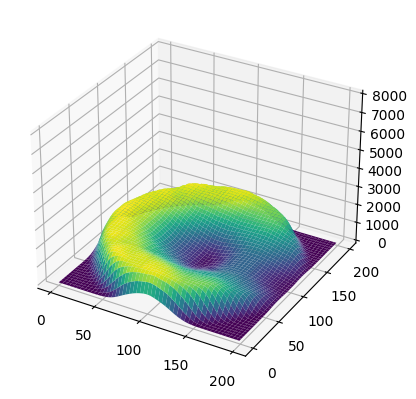

In [43]:
#3d surface plot of heatmap

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = np.arange(200)
y = np.arange(200)
x, y = np.meshgrid(x, y)
z = csr_integrable_coat
ax.plot_surface(x, y, z, cmap='viridis')
ax.set_zlim(0, 8000)
plt.show()

# set z axis to 0 to 700

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = np.arange(200)
y = np.arange(200)
x, y = np.meshgrid(x, y)
z = csr_nonintegrable_coat
ax.plot_surface(x, y, z, cmap='viridis')
ax.set_zlim(0, 8000)
plt.show()

